In [2]:
#importing all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf

In [3]:
#reading data from csv file
data=pd.read_csv('GOOG.csv')
close=data['Close']
len(data)

3809

In [4]:
#plt.plot(date[:6],close[:6])
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,8/19/2004,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,8/20/2004,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,8/23/2004,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,8/24/2004,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,8/25/2004,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


In [5]:
#selecting close feature for prediction
data=data.reset_index()['Close']

In [6]:
#converting data range from 0 to 1 as LSTM is data sensitive
scale=MinMaxScaler(feature_range=(0,1))
data=scale.fit_transform(np.array(data).reshape(-1,1))
data.shape

(3809, 1)

In [7]:
#train and test dataset splitting
train_data=data[:2000]
test_data=data[2000:]

In [8]:
#function to create X,Y for train and test datasets
def create_dataset(dataset,timestep):
    X=[]
    Y=[]
    for i in range(len(dataset)-timestep-1):
        X.append(dataset[i:i+timestep,0])
        Y.append(dataset[i+timestep,0])
    return np.array(X),np.array(Y)

In [9]:
#creating train and test data sets
#taking timestep as 100
X_train,Y_train=create_dataset(train_data,100)
X_test,Y_test=create_dataset(test_data,100)
len(test_data)

1809

In [10]:
#Simple Moving Average technique

Y_avg=[]
sum=0
for i in range(len(Y_test)):
    for j in range(len(test_data)-100-1):
        sum=sum+test_data[j]
    avg=sum/(len(test_data)-100-1)
    Y_avg.append(avg)
    

In [11]:
Y_test[1000:1010]

array([0.59742656, 0.59741044, 0.60292843, 0.60371213, 0.60434227,
       0.59864651, 0.60139343, 0.60318696, 0.60168426, 0.59901817])

In [12]:
Y_avg=scale.fit_transform(np.array(Y_avg).reshape(-1,1))
Y_avg[1000:1010]

array([[0.58582308],
       [0.5864089 ],
       [0.58699473],
       [0.58758055],
       [0.58816637],
       [0.5887522 ],
       [0.58933802],
       [0.58992384],
       [0.59050967],
       [0.59109549]])

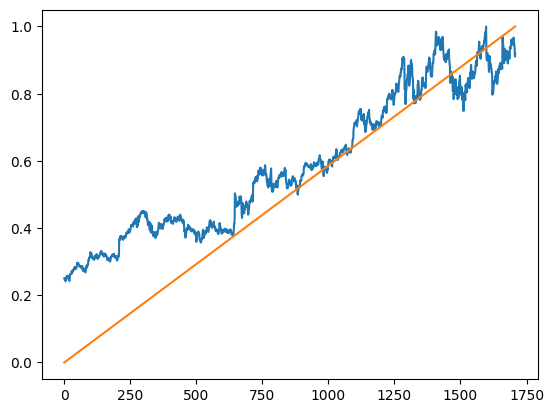

In [13]:
plt.plot(Y_test[:])
plt.plot(Y_avg[:])

In [14]:
#finding mean squared error for predicted and original values in SIMPLE MOVING AVERAGE METHOD
math.sqrt(mean_squared_error(Y_test,Y_avg))

0.131750119949005

In [15]:
#reshaping data into 3 dimesnios i.e.  (samples,timestep,1)
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [16]:
#creating stacked LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))#adding 1st layer of LSTM model
model.add(LSTM(50,return_sequences=True))#adding 2nd LSTM layer
model.add(LSTM(50))#adding 3rd LSTM layer
model.add(Dense(1))#adding final output layer (with single neuron) to LSTM model
model.compile(loss='mean_squared_error',optimizer='adam')#adaptive moment estimation

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [18]:
#training LSTM model
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
30/30 [==============================] - 23s 430ms/step - loss: 0.0035 - val_loss: 0.0683
Epoch 2/10
30/30 [==============================] - 12s 395ms/step - loss: 3.9585e-04 - val_loss: 0.0056
Epoch 3/10
30/30 [==============================] - 9s 289ms/step - loss: 1.5431e-04 - val_loss: 0.0029
Epoch 4/10
30/30 [==============================] - 9s 293ms/step - loss: 1.4128e-04 - val_loss: 0.0024
Epoch 5/10
30/30 [==============================] - 9s 293ms/step - loss: 1.3425e-04 - val_loss: 0.0032
Epoch 6/10
30/30 [==============================] - 7s 236ms/step - loss: 1.2900e-04 - val_loss: 0.0026
Epoch 7/10
30/30 [==============================] - 7s 242ms/step - loss: 1.3163e-04 - val_loss: 0.0028
Epoch 8/10
30/30 [==============================] - 8s 273ms/step - loss: 1.1987e-04 - val_loss: 0.0031
Epoch 9/10
30/30 [==============================] - 8s 262ms/step - loss: 1.1829e-04 - val_loss: 0.0019
Epoch 10/10
30/30 [==============================] - 7s 232ms/step

In [19]:
#predicting values using LSTM model
Y_predicted=model.predict(X_test)
Y_predicted

54/54 [==============================] - 3s 42ms/step


array([[0.2387825 ],
       [0.23993154],
       [0.24108289],
       ...,
       [0.86459386],
       [0.86499476],
       [0.8646268 ]], dtype=float32)

In [20]:
#finding mean squared error for predicted and original values
math.sqrt(mean_squared_error(Y_test,Y_predicted))

0.04564508826462957

Text(0, 0.5, 'CLOSE VALUES')

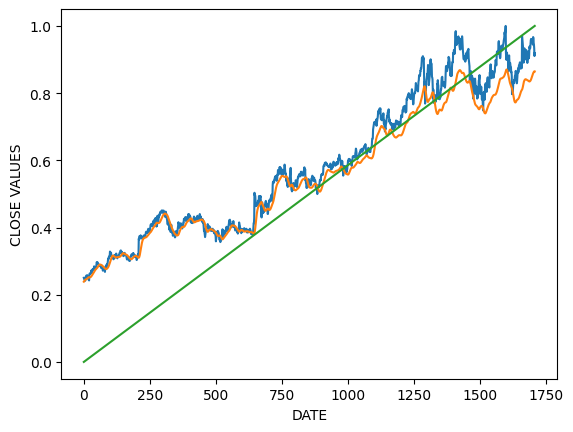

In [22]:
#plotting graphs
plt.plot(Y_test)
plt.plot(Y_predicted)
plt.plot(Y_avg)
plt.xlabel("DATE")
plt.ylabel("CLOSE VALUES")